# Fine Tuning BERT for Sentiment Analysis with PyTorch

Referências
- [Fine Tuning BERT for Sentiment Analysis with PyTorch](https://wellsr.com/python/fine-tuning-bert-for-sentiment-analysis-with-pytorch/)
- [Twitter US Airline Sentiment](https://www.kaggle.com/datasets/crowdflower/twitter-airline-sentiment?select=Tweets.csv)

- [RuntimeError: CUDA out of memory during loss.backward()](https://discuss.pytorch.org/t/runtimeerror-cuda-out-of-memory-during-loss-backward/53450/6)
- [Forms - Colaboratory](https://colab.research.google.com/notebooks/forms.ipynb)
- [Plotting loss curve](https://discuss.pytorch.org/t/plotting-loss-curve/42632/5)

In [1]:
# @title Environment running
running_local = False
if running_local:
    running_colab = running_kaggle = False
else:
    running_colab = False  # @param {type:"boolean"}
    running_kaggle = not running_colab  # @param {type:"boolean"}

In [2]:
if running_colab:
    from google.colab import drive

    drive.mount("/content/drive")

## Installing and Importing Required Libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertModel

In [4]:
RANDOM_SEED = 103
TEST_SIZE = 0.2
BATCH_SIZE = 16
LEARNING_RATE = 2e-5

TOKEN_MAX_LENGTH = 512
MODEL_PATH = "neuralmind/bert-base-portuguese-cased"

In [5]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"There are {torch.cuda.device_count()} GPU(s) available.")
    print("Device name:", torch.cuda.get_device_name(0))
else:
    print("No GPU available, using the CPU instead.")
    device = torch.device("cpu")

There are 2 GPU(s) available.
Device name: Tesla T4


## Importing and Preprocessing the Dataset

In [6]:
if running_colab:
    dataset = pd.read_csv(
        "/content/drive/MyDrive/UFMT/Gestão e Ciência de Dados/Disciplinas/14 - Seminário e Metodologia da Pesquisa/Projetos/glassdoor-reviews-analysis-nlp/data_preparation/glassdoor_reviews_annotated.csv"
    )
else:
    if running_kaggle:
        dataset = pd.read_csv(
            "/kaggle/input/glassdoor-reviews-annotated/glassdoor_reviews_annotated.csv"
        )
    else:
        dataset = pd.read_csv("../data_preparation/glassdoor_reviews_annotated.csv")

In [7]:
dataset.head(2)

,review_id,company,employee_role,employee_detail,review_text,review_date,star_rating,sentiment,annotated
0,82630669,Tecnomapas,Recepcionista,"Ex-funcionário(a), mais de um ano","Companheirismo entre os colegas, oportunidade ...",15 de dez. de 2023,5.0,1,0
1,82630669,Tecnomapas,Recepcionista,"Ex-funcionário(a), mais de um ano",Não tive nenhum ponto negativo,15 de dez. de 2023,5.0,0,1


In [8]:
filtered_dataset = dataset.filter(["review_text", "sentiment"])

In [9]:
filtered_dataset.shape

(2566, 2)

In [10]:
filtered_dataset["sentiment"].value_counts()

sentiment
 1    1284
-1    1035
 0     247
Name: count, dtype: int64

In [11]:
num_labels = len(filtered_dataset["sentiment"].value_counts())

In [12]:
num_labels

3

In [13]:
filtered_dataset.head()

,review_text,sentiment
0,"Companheirismo entre os colegas, oportunidade ...",1
1,Não tive nenhum ponto negativo,0
2,Equipe bem prestativa e ótima de se trabalhar.,1
3,Modo home office ainda tem que ser melhorado.,-1
4,Única vantagem era o trabalho ser home office,0


Replace negative sentiment (-1) to 2, to avoid PyTorch errors.

In [14]:
# sentiment_mapping = {1: 1, 0: 0, -1: 2}

In [15]:
# filtered_dataset["sentiment"] = filtered_dataset["sentiment"].map(sentiment_mapping)

In [16]:
filtered_dataset["sentiment"] = filtered_dataset["sentiment"].apply(
    lambda x: 2 if x == -1 else x
)

In [17]:
filtered_dataset.head()

,review_text,sentiment
0,"Companheirismo entre os colegas, oportunidade ...",1
1,Não tive nenhum ponto negativo,0
2,Equipe bem prestativa e ótima de se trabalhar.,1
3,Modo home office ainda tem que ser melhorado.,2
4,Única vantagem era o trabalho ser home office,0


Shuffle the data before splitting it into training and testing sets to remove any inherent ordering in the data that could bias the model's learning process.

In [18]:
filtered_dataset = filtered_dataset.sample(frac=1, random_state=RANDOM_SEED)

In [19]:
train_data, test_data = train_test_split(
    filtered_dataset, test_size=TEST_SIZE, random_state=RANDOM_SEED
)

In [20]:
train_data.shape

(2052, 2)

In [21]:
test_data.shape

(514, 2)

## Create a PyTorch Dataset

In [22]:
class GlassdoorReviewsDataset(Dataset):
    def __init__(self, data, tokenizer):
        self.data = data
        self.tokenizer = tokenizer
        self.max_length = TOKEN_MAX_LENGTH

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        text = self.data.iloc[index]["review_text"]
        labels = self.data.iloc[index][["sentiment"]].values.astype(int)

        encoding = self.tokenizer(
            text,
            return_tensors="pt",
            padding=True,
            truncation=False,
            # max_length=self.max_length,
        )
        input_ids = encoding["input_ids"][0]
        attention_mask = encoding["attention_mask"][0]

        # resize the tensors to the same size
        input_ids = nn.functional.pad(
            input_ids, (0, self.max_length - input_ids.shape[0]), value=0
        )
        attention_mask = nn.functional.pad(
            attention_mask, (0, self.max_length - attention_mask.shape[0]), value=0
        )

        return input_ids, attention_mask, torch.tensor(labels)

In [23]:
tokenizer = BertTokenizer.from_pretrained(MODEL_PATH)

tokenizer_config.json:   0%|          | 0.00/43.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/210k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/647 [00:00<?, ?B/s]

In [24]:
train_dataset = GlassdoorReviewsDataset(train_data, tokenizer)
test_dataset = GlassdoorReviewsDataset(test_data, tokenizer)

In [25]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

## Creating a PyTorch Model

In [26]:
class GlassdoorReviewsClassifier(nn.Module):
    def __init__(self, num_labels):
        super(GlassdoorReviewsClassifier, self).__init__()

        self.bert = BertModel.from_pretrained(MODEL_PATH)
        self.classifier = nn.Sequential(
            nn.Linear(self.bert.config.hidden_size, 300),
            nn.ReLU(),
            nn.Linear(300, 100),
            nn.ReLU(),
            nn.Linear(100, 50),
            nn.ReLU(),
            nn.Linear(50, num_labels),
            # nn.Linear(self.bert.config.hidden_size, 32),
            # nn.ReLU(),
            # nn.Linear(32, 16),
            # nn.ReLU(),
            # nn.Linear(16, num_labels),
        )

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        x = outputs["last_hidden_state"][:, 0, :]
        x = self.classifier(x)
        return x

### Training the model

In [27]:
model = GlassdoorReviewsClassifier(num_labels).to(device)

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


In [28]:
loss_fun = nn.CrossEntropyLoss()

In [29]:
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [30]:
EPOCHS = 5

In [31]:
n_total_steps = len(train_loader)
n_total_steps

129

In [32]:
train_losses = []
test_losses = []

Old Training Version

In [33]:
# train_losses = []
# for epoch in range(EPOCHS):
#     for i, batch in enumerate(train_loader):
#         input_ids, attention_mask, labels = batch

#         input_ids = input_ids.to(device)
#         attention_mask = attention_mask.to(device)

#         labels = labels.view(-1)
#         labels = labels.to(device)

#         optimizer.zero_grad()

#         logits = model(input_ids, attention_mask)

#         loss = loss_fun(logits, labels)
#         train_losses.append(loss.item())

#         loss.backward()
#         optimizer.step()

#         if (i + 1) % BATCH_SIZE == 0:
#             print(
#                 f"Epoch {epoch + 1} / {EPOCHS}, batch {i + 1}/{n_total_steps}, loss = {loss.item():.4f}"
#             )

New Training Version

In [34]:
def train(model, data_loader, loss_fun, optimizer):
    model.train()

    running_loss = 0.0
    for i, batch in enumerate(data_loader):
        input_ids, attention_mask, labels = batch

        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)

        labels = labels.view(-1)
        labels = labels.to(device)

        optimizer.zero_grad()

        logits = model(input_ids, attention_mask)

        loss = loss_fun(logits, labels)

        loss.backward()
        optimizer.step()

        loss_value = loss.item()
        running_loss += loss_value

        if (i + 1) % BATCH_SIZE == 0:
            print(
                f"Training Batch {i + 1}/{n_total_steps}, \t\t loss = {loss_value:.4f}"
            )

    return running_loss / len(data_loader)

In [35]:
def test(model, data_loader, loss_fun):
    model.eval()

    running_loss = 0.0
    with torch.no_grad():
        for i, batch in enumerate(data_loader):
            input_ids, attention_mask, labels = batch

            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)

            labels = labels.view(-1)
            labels = labels.to(device)

            logits = model(input_ids, attention_mask)
            loss = loss_fun(logits, labels)

            loss_value = loss.item()
            running_loss += loss_value

            if (i + 1) % BATCH_SIZE == 0:
                print(
                    f"Evaluating Batch {i + 1}/{n_total_steps}, \t\t loss = {loss_value:.4f}"
                )

    return running_loss / len(data_loader)

In [36]:
for t in range(EPOCHS):
    print(f"{'-'*20} Epoch: {t + 1}/{EPOCHS} {'-'*20}")

    train_loss = train(model, train_loader, loss_fun, optimizer)
    train_losses.append(train_loss)

    print("")

    test_loss = test(model, test_loader, loss_fun)
    test_losses.append(test_loss)

    print(f"\nTrain Loss: {train_loss}, \t\t Test Loss: {test_loss}")
    print("\n\n")

-------------------- Epoch: 1/5 --------------------
Training Batch 16/129, 	 loss = 1.0903
Training Batch 32/129, 	 loss = 0.9241
Training Batch 48/129, 	 loss = 0.7730
Training Batch 64/129, 	 loss = 0.7344
Training Batch 80/129, 	 loss = 0.8138
Training Batch 96/129, 	 loss = 0.7306
Training Batch 112/129, 	 loss = 0.6230
Training Batch 128/129, 	 loss = 0.4134


Evaluating Batch 16/129, 	 loss = 0.7394
Evaluating Batch 32/129, 	 loss = 0.5592

Train Loss: 0.7965584459692933, 	 Test Loss: 0.5077926534594912

-------------------- Epoch: 2/5 --------------------
Training Batch 16/129, 	 loss = 0.6027
Training Batch 32/129, 	 loss = 0.2817
Training Batch 48/129, 	 loss = 0.4740
Training Batch 64/129, 	 loss = 0.4584
Training Batch 80/129, 	 loss = 0.2868
Training Batch 96/129, 	 loss = 0.2661
Training Batch 112/129, 	 loss = 0.3873
Training Batch 128/129, 	 loss = 0.2556


Evaluating Batch 16/129, 	 loss = 0.6933
Evaluating Batch 32/129, 	 loss = 0.2923

Train Loss: 0.3826923276218333,

In [38]:
def show_loss(train_loss_per_epoch, test_loss_per_epoch):
    epochs = range(1, len(train_loss_per_epoch) + 1)

    train_data = {"epoch": epochs, "loss": train_loss_per_epoch, "type": "train"}
    test_data = {"epoch": epochs, "loss": test_loss_per_epoch, "type": "test"}
    df_loss = pd.concat([pd.DataFrame(train_data), pd.DataFrame(test_data)])

    plt.figure(figsize=(8, 6))
    sns.lineplot(data=df_loss, x="epoch", y="loss", hue="type", marker="o")

    plt.title("Training and Test Loss per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")

    # plt.grid(True)
    plt.legend(title="Loss Type")
    plt.show()

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to 

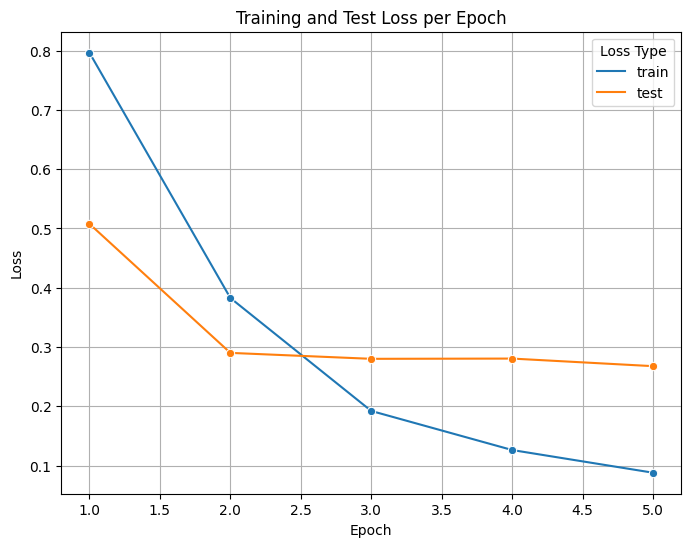

In [39]:
show_loss(train_losses, test_losses)

### Evaluating the Model

In [40]:
all_labels = []
all_preds = []

with torch.no_grad():
    n_correct = 0
    n_samples = 0

    for i, batch in enumerate(test_loader):
        input_ids, attention_mask, labels = batch

        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)

        labels = labels.view(-1)
        labels = labels.to(device)

        outputs = model(input_ids, attention_mask)
        _, predictions = torch.max(outputs, 1)

        all_labels.append(labels.cpu().numpy())
        all_preds.append(predictions.cpu().numpy())


all_labels = np.concatenate(all_labels, axis=0)
all_preds = np.concatenate(all_preds, axis=0)

In [ ]:
# TODO: fazer oversampling na classe neutral devido ao desbalanceamento e retreinar. Mostrar o classification_report de antes e depois do oversampling.

In [41]:
print(classification_report(all_labels, all_preds))

              precision    recall  f1-score   support

           0       0.84      0.71      0.77        45
           1       0.96      0.95      0.96       264
           2       0.91      0.95      0.93       205

    accuracy                           0.93       514
   macro avg       0.90      0.87      0.89       514
weighted avg       0.93      0.93      0.93       514



In [42]:
print(accuracy_score(all_labels, all_preds))

0.9299610894941635


In [ ]:
# TODO: fazer oversampling da classe neutral mostrar antes e depois da matriz de confusão

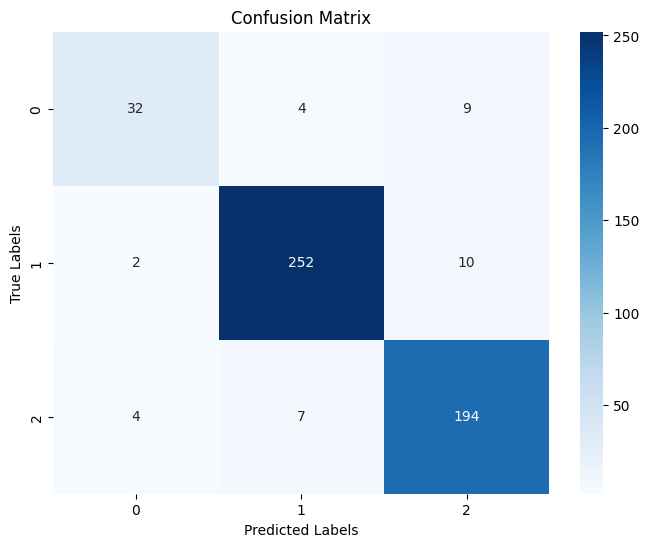

In [43]:
cm = confusion_matrix(all_labels, all_preds, normalize=True)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap="Blues", fmt="g")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

## Saving the model

In [53]:
torch.save(model.state_dict(), f"bertimbau-glassdoor-reviews-epoch_{t + 1}.bin")

## Loading the model

In [70]:
tokenizer = BertTokenizer.from_pretrained(MODEL_PATH)

In [71]:
GLASSDOOR_MODEL_PATH = "/kaggle/working/bertimbau-glassdoor-reviews-epoch_5.bin"

In [83]:
loaded_model = GlassdoorReviewsClassifier(num_labels).to(device)
loaded_model.load_state_dict(torch.load(GLASSDOOR_MODEL_PATH, map_location=device))
loaded_model.eval()

GlassdoorReviewsClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(29794, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, el

## Sample prediction

In [96]:
tests = [
    "Empresa boa para trabalhar",
    "Empresa ruim para trabalhar",
    "Não tenho o que declarar",
]

In [99]:
class_names = ["neutral", "positive", "negative"]
for test in tests:
    encoded_review = tokenizer.encode_plus(
        test,
        max_length=TOKEN_MAX_LENGTH,
        add_special_tokens=True,
        return_token_type_ids=False,
        # pad_to_max_length=True, # deprecated
        padding="max_length",
        truncation=True,
        return_attention_mask=True,
        return_tensors="pt",
    )

    input_ids = encoded_review["input_ids"].to(device)
    attention_mask = encoded_review["attention_mask"].to(device)

    output = loaded_model(input_ids, attention_mask)
    _, prediction = torch.max(output, dim=1)
    probs = nn.functional.softmax(output, dim=1)

    print(f"Review text: {test}")
    # print(probs)
    print(pd.DataFrame(probs.tolist()[0], class_names)[0])
    print("\n")

Review text: Empresa boa para trabalhar
tensor([[0.0074, 0.9875, 0.0051]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
neutral     0.007380
positive    0.987479
negative    0.005141
Name: 0, dtype: float64


Review text: Empresa ruim para trabalhar
tensor([[0.0082, 0.0024, 0.9894]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
neutral     0.00823
positive    0.00240
negative    0.98937
Name: 0, dtype: float64


Review text: Não tenho o que declarar
tensor([[0.9454, 0.0276, 0.0270]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
neutral     0.945414
positive    0.027622
negative    0.026964
Name: 0, dtype: float64


